# Impact of 401(k) on Financial Assets

## Data explanation
1991 Survey of Income and Program Participation

- **net_tfa** — *Net Total Financial Assets*.
  Calculated as the sum of all liquid and interest-earning assets (IRA balances, 401(k) balances, checking accounts, U.S. savings bonds, other interest‐earning accounts, stocks, mutual funds, etc.) **minus** non‐mortgage debts.

- **e401** — *401(k) Eligibility Indicator*.
  Equals 1 if the individual's employer offers a 401(k) plan; otherwise 0.

- **p401** — *401(k) Participation Indicator*.
  Equals 1 if the individual participate in 401(k) plan; otherwise 0.

- **age** — *Age*.
  Age of the individual in years.

- **inc** — *Annual Income*.
  Annual income of the individual, measured in U.S. dollars for the year 1990.

- **educ** — *Years of Education*.
  Number of completed years of formal education.

- **fsize** — *Family Size*.
  Total number of persons living in the household.

- **marr** — *Marital Status*.
  Equals 1 if the individual is married; otherwise 0.

- **twoearn** — *Two-Earner Household*.
  Equals 1 if there are two wage earners in the household; otherwise 0.

- **db** — *Defined-Benefit Pension Plan*.
  Equals 1 if the individual is covered by a defined-benefit pension plan; otherwise 0.

- **pira** — *IRA Participation*.
  Equals 1 if the individual contributes to an Individual Retirement Account (IRA); otherwise 0.

- **hown** — *Home Ownership*.
  Equals 1 if the household owns its home; 0 if renting.

We download it with fetch_401K function from doubleML.datasets

This dataset has a problem. confounders were measured in the same year as treatment and outcome,
 like they are demographic factors that do not change over time. So inference might still be biased.

In [1]:
from doubleml.datasets import fetch_401K
df = fetch_401K(return_type='DataFrame')

In [2]:
# don't know what they mean
df = df.drop(columns=['tw', 'nifa'])
# eligibility for 401k, drop because it's an instrument
df = df.drop(columns=['e401'])

df.columns

Index(['net_tfa', 'age', 'inc', 'fsize', 'educ', 'db', 'marr', 'twoearn',
       'p401', 'pira', 'hown'],
      dtype='object')

In [3]:
from causalis.data import CausalData
causal_data = CausalData(df=df, treatment='p401',
                         outcome='net_tfa',
                         confounders=['age', 'inc', 'fsize', 'educ', 'db', 'marr', 'twoearn', 'pira', 'hown'])

## EDA

In [4]:
from causalis.eda import CausalEDA
eda = CausalEDA(causal_data)

# shape of data
eda.data_shape()

{'n_rows': 9915, 'n_columns': 11}

In [5]:
# 1) Outcome statistics by treatment
from causalis.statistics.functions import outcome_stats
outcome_stats(causal_data)

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0,7321,10890.477539,55256.829173,-502302.0,-5427.0,-1184.0,200.0,7399.0,33500.0,1462115.0
1,2594,38262.058594,79087.535303,-283356.0,-1300.0,3000.0,15249.0,45985.5,98887.4,1536798.0


Participants’ average net worth is ≈28k higher, but this gap cannot be causally attributed
solely to participation. The classes are imbalanced—only 26% are treated.

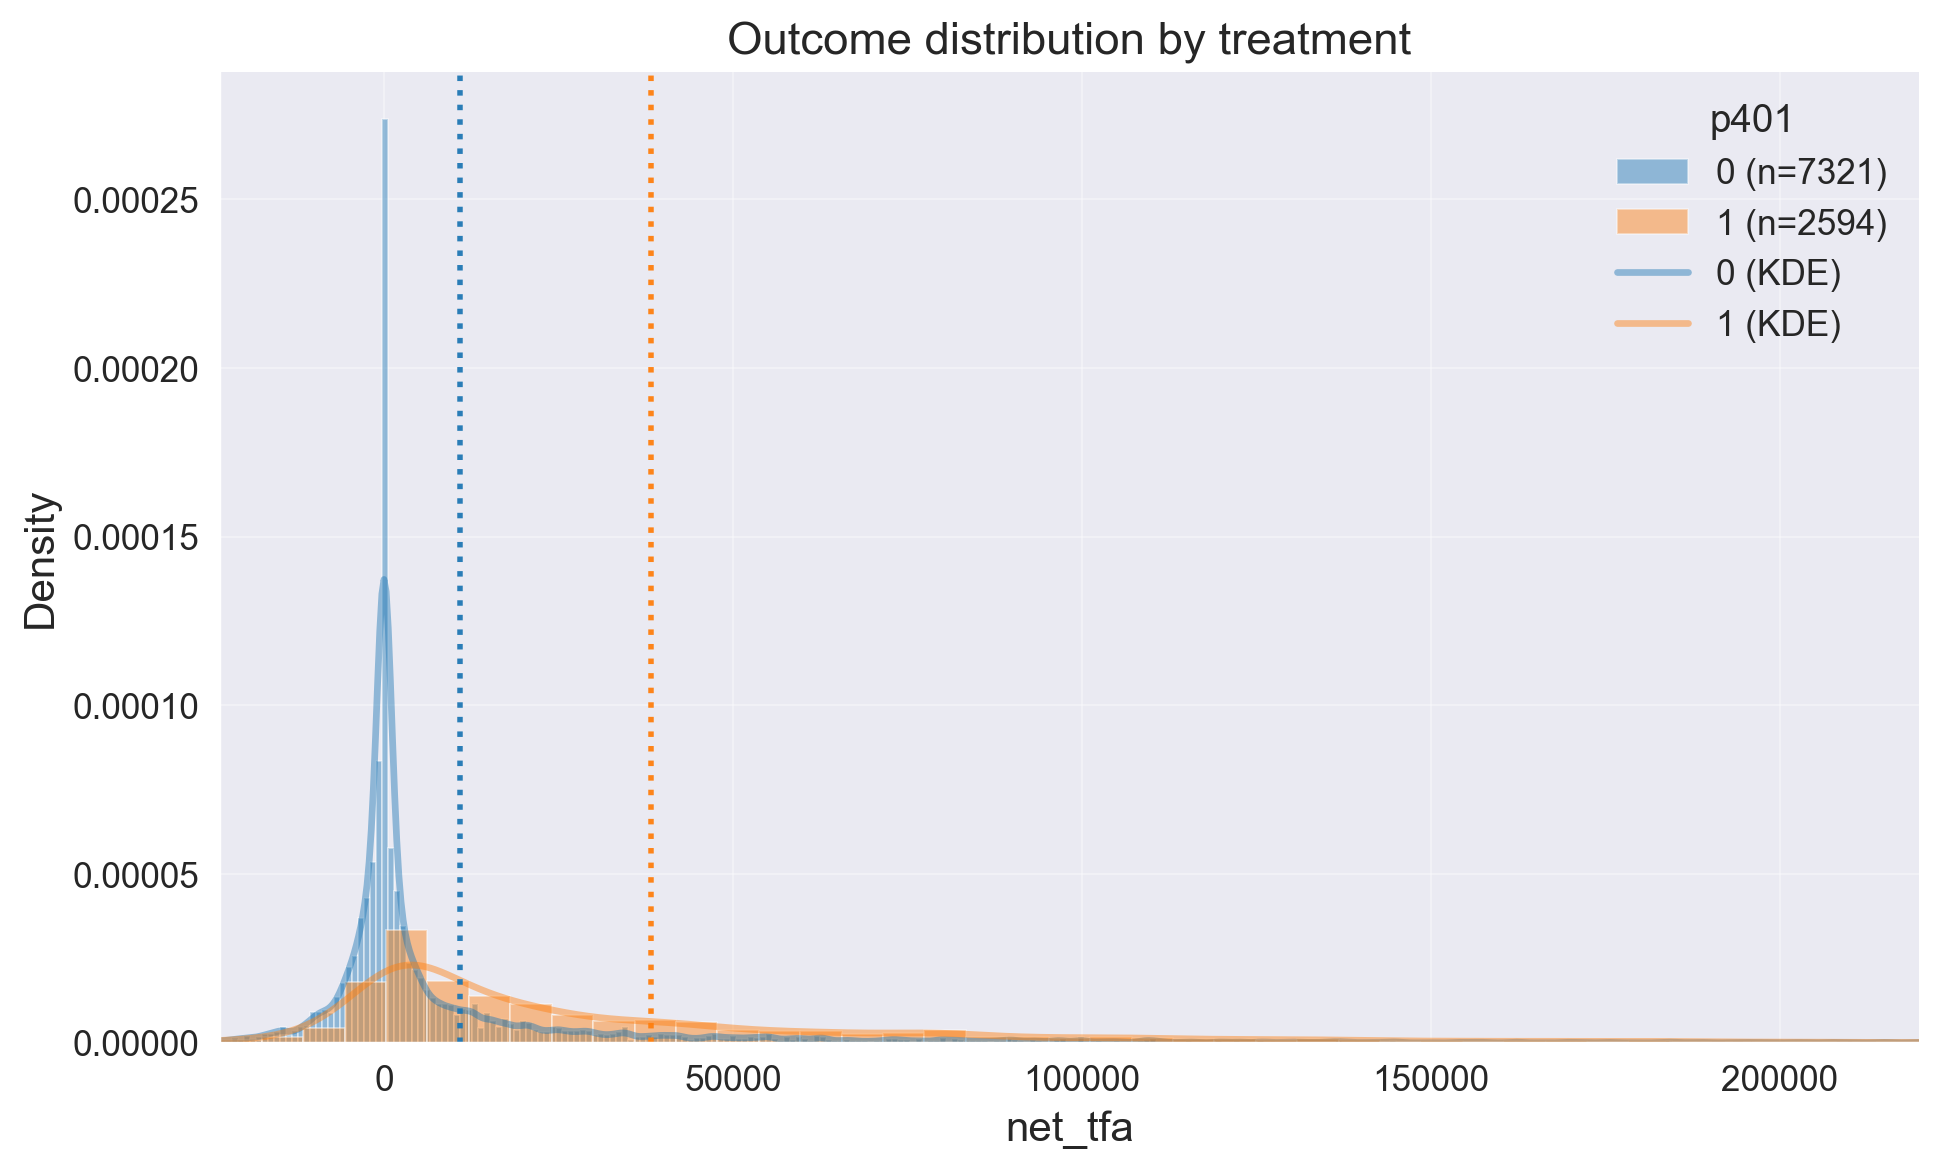

In [6]:
eda.outcome_hist()

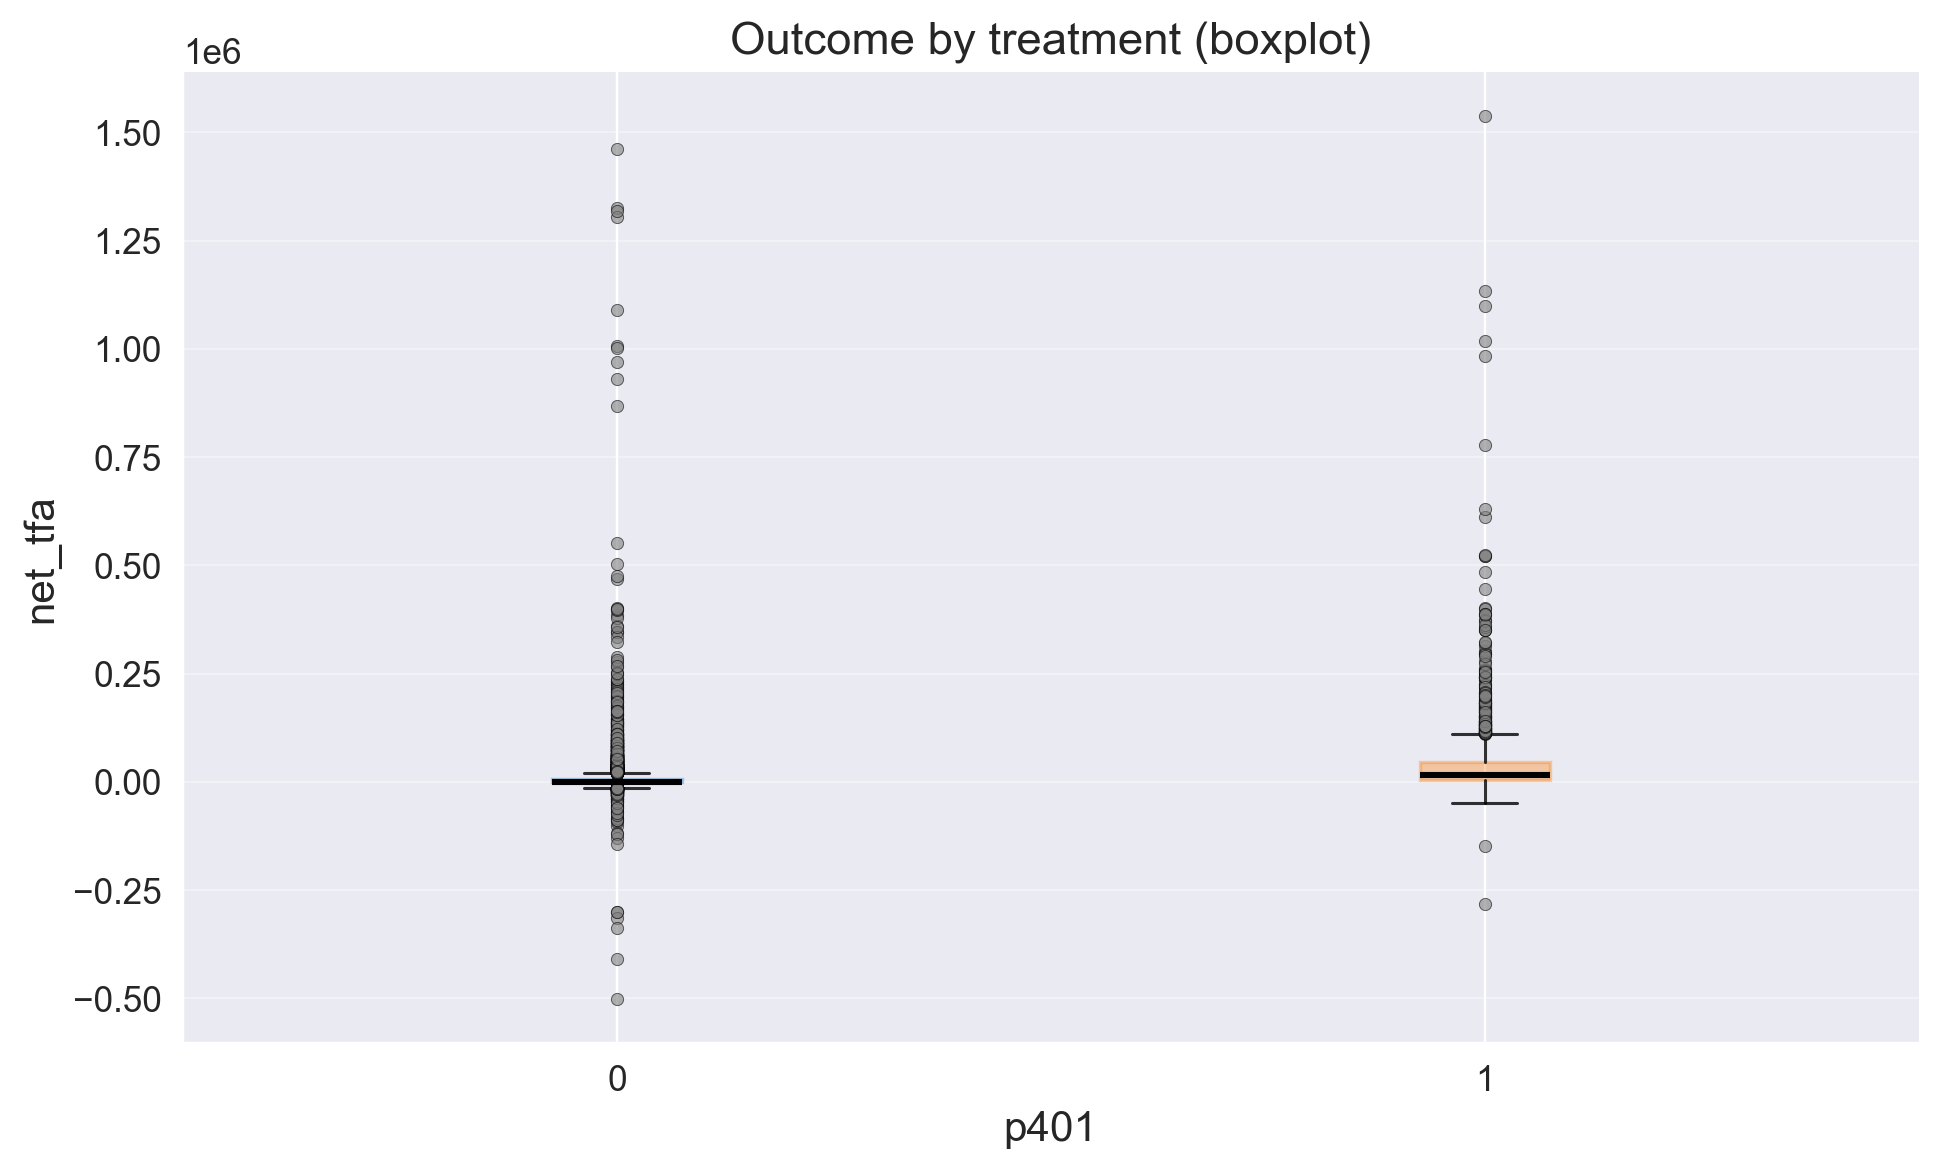

In [7]:
eda.outcome_boxplot()

Our outcome has large right tail

In [8]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd
cofounders,,,,
inc,32889.802486,49366.975713,16477.173227,0.662197
hown,0.589127,0.765227,0.176100,0.383456
pira,0.200246,0.360447,0.160201,0.362421
db,0.228248,0.391673,0.163426,0.358968
twoearn,0.337659,0.502699,0.165040,0.339096
educ,12.991121,13.813416,0.822294,0.299061
marr,0.574512,0.690439,0.115928,0.242175
age,40.900970,41.509638,0.608668,0.060108
fsize,2.848108,2.915960,0.067852,0.044731


Treatment and control are unbalanced on all confounders except age and fsize; nonetheless,
we retain age and fsize in the model to gain efficiency

In [9]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.7145


In [10]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.08371154815935451, 'share_above': 0.0, 'flag': True}


In [11]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean,shap_mean_abs,exact_pp_change_abs,exact_pp_change_signed
0,num__inc,0.006932,0.583319,0.126203,0.001334
1,num__fsize,0.005461,0.080593,0.015778,0.001050
2,num__age,-0.004583,0.154312,0.030720,-0.000879
3,num__marr,-0.004524,0.030119,0.005827,-0.000868
4,num__educ,-0.003760,0.121098,0.023929,-0.000722
5,num__hown,0.001024,0.187255,0.037551,0.000197
6,num__db,-0.000816,0.272325,0.055610,-0.000157
7,num__twoearn,0.000228,0.043159,0.008376,0.000044
8,num__pira,0.000038,0.129544,0.025647,0.000007


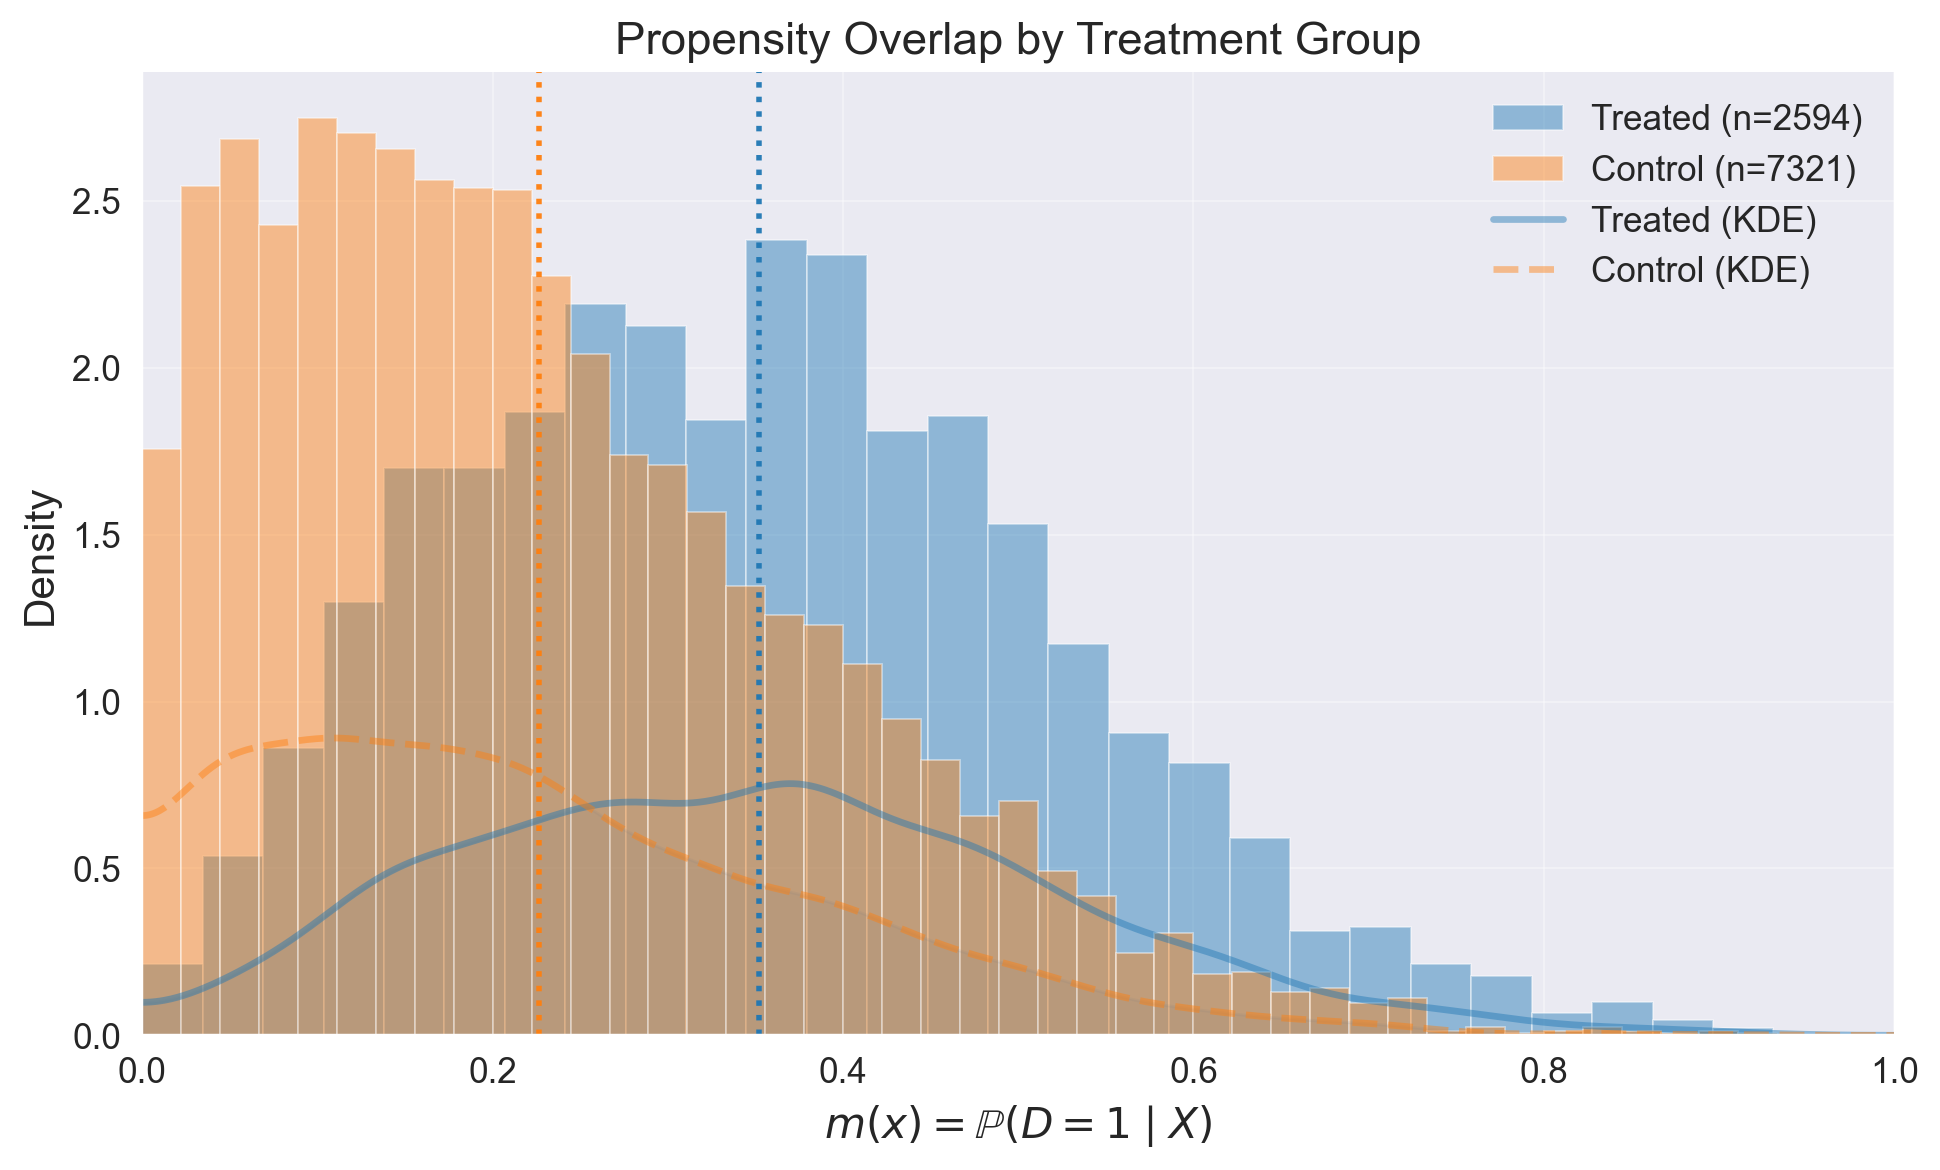

In [12]:
# Propensity score overlap graph
ps_model.plot_m_overlap()

In [13]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 60189.944724760215, 'mae': 20331.55384475013}


In [14]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,inc,731.774932
1,pira,-683.388458
2,age,370.619026
3,marr,-189.688960
4,educ,-133.732826
5,twoearn,-106.324198
6,fsize,68.288189
7,db,-32.271609
8,hown,-25.276096


## Inference

In [15]:
from causalis.scenarios.unconfoundedness.ate import dml_ate

# Estimate Average Treatment Effect (ATE)
ate_result = dml_ate(causal_data, n_folds=4, alpha=0.05)

In [16]:
print(ate_result.get('coefficient'))
print(ate_result.get('p_value'))
print(ate_result.get('confidence_interval'))

11250.6922050985
4.0745185003743245e-13
(8210.458854591107, 14290.925555605892)


Average Treatment Effect is significant and equals 11385 dollars in CI bounds (8674, 14096)

## Refutation

### Overlap validation

In [17]:
from causalis.scenarios.unconfoundedness.refutation import *
rep = run_overlap_diagnostics(res=ate_result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.000000,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.026828,GREEN
3,edge_0.02_above,0.000000,GREEN
4,KS,0.307200,YELLOW
5,AUC,0.706812,GREEN
6,ESS_treated_ratio,0.365399,GREEN
7,ESS_control_ratio,0.893936,GREEN
8,tails_w1_q99/med,33.171484,YELLOW
9,tails_w0_q99/med,5.250310,GREEN


We find no evidence of a violation of the overlap (positivity) assumption.

### Score validation

In [18]:
from causalis.scenarios.unconfoundedness.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(res=ate_result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,1551.167968,NA
1,psi_p99_over_med,36.192430,RED
2,psi_kurtosis,263.310341,RED
3,max_|t|_g1,3.951050,YELLOW
4,max_|t|_g0,2.472043,YELLOW
5,max_|t|_m,1.875749,GREEN
6,oos_tstat_fold,0.000028,GREEN
7,oos_tstat_strict,0.000028,GREEN


We see that psi_p99_over_med and psi_kurtosis are RED. That's because large tail in outcome. We find no evidence of anomaly score behavior

### SUTVA

In [19]:
print_sutva_questions()

1.) Are your clients independent (i)?
2.) Do you measure cofounders, treatment, and outcome in the same intervals?
3.) Do you measure cofounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


1.) Yes\
2.) Yes\
3.) No. We have problems with design\
4.) Yes\
In conclusion confounders are measured not before treatment. So treatment affected confounders

### Uncofoundedness

In [20]:
from causalis.scenarios.unconfoundedness.refutation.uncofoundedness.uncofoundedness_validation import run_uncofoundedness_diagnostics

rep_uc = run_uncofoundedness_diagnostics(res=ate_result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,7.606060e-02,GREEN
1,balance_frac_violations,0.000000e+00,GREEN
2,ess_treated_ratio,3.653986e-01,RED
3,ess_control_ratio,8.939358e-01,GREEN
4,w_tail_ratio_treated,1.218068e+13,RED
5,w_tail_ratio_control,2.482226e+00,GREEN
6,top1_mass_share_treated,2.137807e-01,GREEN
7,top1_mass_share_control,3.937273e-02,GREEN
8,ks_m_treated_vs_control,3.071998e-01,YELLOW
9,pct_m_outside_overlap,9.783157e-01,GREEN


We see w_tail_ratio_treated and ess_treated_ratio are RED. It's ok. These tests are unstable due to small sample

In [21]:
from causalis.scenarios.unconfoundedness.refutation.uncofoundedness.uncofoundedness_validation import (
    sensitivity_analysis, sensitivity_benchmark
)

sensitivity_analysis(ate_result, cf_y=0.01, cf_d=0.01, rho=1.0, level=0.95, use_signed_rr=True)

{'theta': 11250.6922050985,
 'se': 1551.1679676200004,
 'level': 0.95,
 'z': 1.959963984540054,
 'sampling_ci': (8210.458854591107, 14290.925555605892),
 'theta_bounds_cofounding': (10298.960958424657, 12202.423451772342),
 'bias_aware_ci': (7258.727607917263, 15242.656802279736),
 'max_bias': 951.7312466738426,
 'sigma2': 3589568447.751854,
 'nu2': 0.37645320639967106,
 'params': {'cf_y': 0.01, 'cf_d': 0.01, 'rho': 1.0, 'use_signed_rr': True}}

Even when we have unobserved confounder with these parameters our CI bounds > 0

In [22]:
sensitivity_benchmark(ate_result, benchmarking_set =['inc'])

/Users/ioannmartynov/PycharmProjects/Ckit/causalis/data/causaldata.py:108: UserWarning: Found 112 duplicate rows out of 9915 total rows in the DataFrame. This leaves 9803 unique rows for analysis. Duplicate rows may affect the quality of causal inference results. Consider removing duplicates if they are not intentional.
  self._check_duplicate_rows(self.df)


,cf_y,cf_d,rho,theta_long,theta_short,delta
p401,0.000041,0.000004,-1.0,11250.692205,14355.071728,-3104.379523


And even when unobserved confounder is strong as 'inc' - income our estimate has CI bounds > 0

## Conclution

There are problems with design: confounders are measured not before treatment. So treatment affected confounders.
However estimate is robust and in real life participation in 401k is increasing net financial assets. To keep in mind real CI bounds may differ from our estimation